In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.transforms import Bbox
import os
%config InlineBackend.figure_format = 'svg'

In [2]:
# Define a custom color palette for consistent visualization throughout the notebook
colors = ["#787cce", "#ffc533","#62b58f","#f2726f","#bc95df","#67cdf2","#29c3be","#3c3c3c","#8e5a2c"]
sns.set_palette(sns.color_palette(colors))
sns.color_palette()

[(0.47058823529411764, 0.48627450980392156, 0.807843137254902),
 (1.0, 0.7725490196078432, 0.2),
 (0.3843137254901961, 0.7098039215686275, 0.5607843137254902),
 (0.9490196078431372, 0.4470588235294118, 0.43529411764705883),
 (0.7372549019607844, 0.5843137254901961, 0.8745098039215686),
 (0.403921568627451, 0.803921568627451, 0.9490196078431372),
 (0.1607843137254902, 0.7647058823529411, 0.7450980392156863),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.5568627450980392, 0.35294117647058826, 0.17254901960784313)]

In [3]:
# Create a modified BuPu colormap with enhanced contrast in the upper range (0.7-1.0)
from matplotlib.colors import LinearSegmentedColormap

points_0_to_04 = np.linspace(0, 0.7, 128, endpoint=False)
points_04_to_1 = np.linspace(0.7, 1, 128)
points_combined = np.concatenate((points_0_to_04, points_04_to_1))
BuPu_new = LinearSegmentedColormap.from_list("BuPu_modified", matplotlib.colormaps.get_cmap("BuPu")(points_combined))

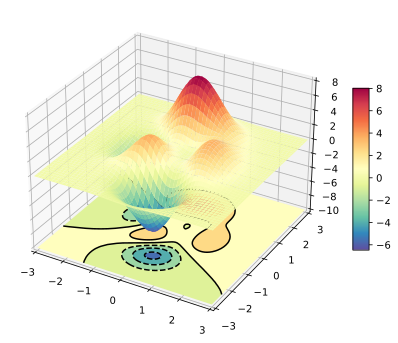

In [4]:
# Fig. 2 in the manuscript
# Create a 3D visualization of a complex function to demonstrate optimization landscape
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
x, y = np.meshgrid(x, y)
z = (3*(1-x)**2 * np.exp(-x**2 - (y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='Spectral_r')

ax.contour(x, y, z, colors = 'black', offset = -10)
ax.contourf(x, y, z, cmap = 'Spectral_r', offset = -10, alpha = 1)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-10, 8)

fig.colorbar(surf, shrink=0.5, aspect=10,pad=0.05)
plt.tight_layout()
plt.savefig(f'./figures/optimal.pdf', bbox_inches='tight')

In [5]:
# Table 2 in the manuscript
df_chiller= pd.read_csv("./chiller_info.csv",index_col='Chiller')
N = len(df_chiller)
df_chiller

,a,b,c,d,Capacity/(RT)
Chiller,,,,,
1,399.345,-122.12,770.46,0,1280
2,287.116,80.04,700.48,0,1280
3,-120.505,1525.99,-502.14,0,1280
4,-19.121,898.76,-98.15,0,1280
5,-95.029,1202.39,-352.16,0,1250
6,191.750,224.86,524.04,0,1250


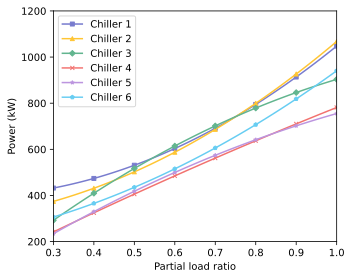

In [6]:
def plr_kw(df_chiller,chiller_no,plr):
    # Calculates the power consumption (kW) of a chiller at a given partial load ratio using its performance coefficients.
    a,b,c,d = df_chiller.loc[chiller_no][:4]
    return a+b*plr+c*plr**2+d*plr**3

def plot_plr_kw(df_chiller,chiller_no):
    # Plots the power consumption curve for a specific chiller across different partial load ratios with distinctive markers.
    markers = ["o", "s", "^", "D", "x", "*", "p", "h", "+", "v"]
    plrs = np.arange(0.3,1.01,0.01)
    kws = np.array(list(map(lambda plr:plr_kw(df_chiller,chiller_no,plr),plrs)))
    plt.plot(plrs,kws,label=f'Chiller {chiller_no}',marker=markers[chiller_no],markevery=10,markersize=4)

abcd = df_chiller.values[:,:-1] # Chiller performance coefficients
cap_array = np.array(df_chiller.iloc[:,-1])


# Fig. 4 in the manuscript
plt.figure(figsize=(5,4))
for chiller_no in df_chiller.index:
    plot_plr_kw(df_chiller,chiller_no)
plt.xlim(0.3,1)
plt.legend(edgecolor='#d6d6d6',framealpha=1)
plt.xlabel('Partial load ratio')
plt.ylabel('Power (kW)')
plt.ylim(200,1200)
plt.tight_layout()
plt.savefig(f'./figures/chiller_info.pdf', bbox_inches='tight')

In [7]:
# Implementation of baseline metaheuristic algorithms for chiller loading optimization
from sko.GA import GA
from sko.DE import DE
from sko.PSO import PSO
from sko.SA import SA,SAFast

lb=[0]*N
ub=[1]*N

def adjust_p(p, load):
    # Adjusts chiller partial load ratios to match the required total load by incrementally modifying the highest or lowest active chiller.
    
    p[p < 0.01] = 0
    p[p > 0.99] = 1
    current_load = (p * cap_array).sum()
    while np.abs(current_load - load) > 1e-6:
        if current_load > load:
            not_one = p < 1
            if not_one.any():
                max_val_index = np.where(p == p[not_one].max())[0][0]
                p[max_val_index] -= min((current_load - load) / cap_array[max_val_index], p[max_val_index])
        else:
            not_zero = p > 0
            if not_zero.any():
                min_val_index = np.where(p == p[not_zero].min())[0][0]
                p[min_val_index] += min((load - current_load) / cap_array[min_val_index], 1 - p[min_val_index])
        current_load = (p * cap_array).sum()
    return p

def de(load,best_x_previous):
    # Differential Evolution algorithm that optimizes chiller loading to minimize power consumption while meeting the required load.
    def kw(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()
    def kws(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum(axis=1)
    def bias(p):
        return abs(sum(cap_array*p)-load)
    def target(p):
        p = np.where(p < 0.3, 0, p)
        return kw(p)+bias(p)
    opt = DE(func=target,n_dim=N,lb=lb, ub=ub)
    best_x, best_y = opt.run()
    best_x = np.where(best_x < 0.3, 0, best_x)
    cap_max = ((best_x>0).astype(int)*cap_array).sum()
    if cap_max*0.3 <= load <= cap_max:
        best_x = adjust_p(best_x,load)
    else:
        best_x = adjust_p(best_x_previous,load)
    return best_x,kw(best_x)

def ga(load,best_x_previous):
    # Genetic Algorithm that finds optimal chiller loading patterns to minimize power consumption while satisfying the required load.
    def kw(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()
    def kws(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum(axis=1)
    def bias(p):
        return abs(sum(cap_array*p)-load)
    def target(p):
        p = np.where(p < 0.3, 0, p)
        return kw(p)+bias(p)
    opt = GA(func=target,n_dim=N,lb=lb, ub=ub,size_pop=100,prob_mut=0.01)
    best_x, best_y = opt.run()
    best_x = np.where(best_x < 0.3, 0, best_x)
    cap_max = ((best_x>0).astype(int)*cap_array).sum()
    if cap_max*0.3 <= load <= cap_max:
        best_x = adjust_p(best_x,load)
    else:
        best_x = adjust_p(best_x_previous,load)
    return best_x,kw(best_x)

def pso(load,best_x_previous):
    # Particle Swarm Optimization algorithm that determines optimal chiller loading to minimize power consumption while meeting the required load.
    def kw(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()
    def kws(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum(axis=1)
    def bias(p):
        return abs(sum(cap_array*p)-load)
    def target(p):
        p = np.where(p < 0.3, 0, p)
        return kw(p)+bias(p)
    opt = PSO(func=target,n_dim=N,lb=lb, ub=ub)
    best_x, best_y = opt.run()
    best_x = np.where(best_x < 0.3, 0, best_x)
    cap_max = ((best_x>0).astype(int)*cap_array).sum()
    if cap_max*0.3 <= load <= cap_max:
        best_x = adjust_p(best_x,load)
    else:
        best_x = adjust_p(best_x_previous,load)
    return best_x,kw(best_x)

def sa(load,best_x_previous):
    """Simulated Annealing algorithm that optimizes chiller loading distribution to minimize power consumption while meeting the required cooling load."""
    def kw(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()
    def kws(p):
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum(axis=1)
    def bias(p):
        return abs(sum(cap_array*p)-load)
    def target(p):
        p = np.where(p < 0.3, 0, p)
        return kw(p)+bias(p)
    opt = SA(func=target,x0=[0.5]*N,n_dim=N,lb=lb, ub=ub)
    best_x, best_y = opt.run()
    best_x = np.where(best_x < 0.3, 0, best_x)
    cap_max = ((best_x>0).astype(int)*cap_array).sum()
    if cap_max*0.3 <= load <= cap_max:
        best_x = adjust_p(best_x,load)
    else:
        best_x = adjust_p(best_x_previous,load)
    return best_x,kw(best_x)

In [8]:
# Gurobi solver implementation for optimal chiller loading using mixed-integer quadratic programming
from gurobipy import *

def Gurobi(load):
    # Gurobi optimization solver that uses mixed-integer quadratic programming to find the optimal chiller loading.
    m = Model("quadratic_optimization")
    m.setParam('OutputFlag', 0)

    a = abcd[:,0]
    b = abcd[:,1]
    c = abcd[:,2]
    w = cap_array

    x = m.addVars(6, lb=0.3, ub=1, name="x")
    k = m.addVars(6, vtype=GRB.BINARY, name="k")
    p = m.addVars(6, lb=0, ub=1, name="p")

    objective = quicksum(a[i] + b[i] * p[i] + c[i] * p[i] * p[i] for i in range(6))
    m.setObjective(objective, GRB.MINIMIZE)

    for i in range(6):
        m.addConstr(p[i] <= x[i], name=f"p_upper_bound_{i}")
        m.addConstr(p[i] <= k[i], name=f"p_upper_bound_k_{i}")
        m.addConstr(p[i] >= x[i] - (1 - k[i]), name=f"p_lower_bound_{i}")

    m.addConstr(quicksum(p[i] * w[i] for i in range(6)) == load, "load_constraint")

    m.optimize()

    p_values = m.getAttr('x', p)

    best_x = np.array([p_values[i] for i in range(6)])
    best_x = adjust_p(best_x,load)

    return best_x,m.objVal


In [9]:
df_cl = pd.read_csv('./cooling_load.csv',index_col=0,parse_dates=True).asfreq('30min').CL
cl_selected = []
for day in range(1, 31):
    date_str = f'2022-08-{day:02d}'
    daily_data = df_cl[date_str]
    daily_data[daily_data<200] = np.nan
    daily_data = daily_data.interpolate()
    cl_selected.append(daily_data*2) # Since the cooling load of the building is not as large as the chiller configurations in Table 2, the actual cooling load was multiplied by 2

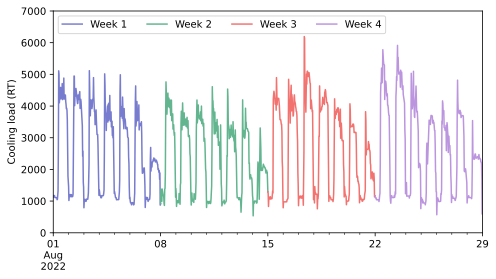

In [10]:
# Fig. 5 in the manuscript
date_range = pd.date_range('2022-08-01', periods=28, freq='D')
start_dates = [pd.to_datetime('2022-08-01') + pd.DateOffset(weeks=i) for i in range(4)]
end_dates = [start_date + pd.DateOffset(weeks=1) for start_date in start_dates]

plt.figure(figsize=(7, 4))
for i in range(4):
    df_week = df_cl[start_dates[i]:end_dates[i]]*2
    if i < 1:
        df_week.interpolate().plot(label='Week {}'.format(i+1), color=colors[i])
    else:
        df_week.interpolate().plot(label='Week {}'.format(i+1), color=colors[i+1])

plt.xlim('2022-8-1 0:0', '2022-8-29 0:0')
plt.legend(edgecolor='#d6d6d6',framealpha=1,ncols=4,loc='upper left')
plt.ylim(0,7000)
plt.ylabel('Cooling load (RT)')

# 设置x轴刻度
# plt.xticks(pd.date_range('2022-08-01', '2022-08-29', freq='7D'), [d.strftime("%d\n%b\n%Y") for d in pd.date_range('2022-08-01', '2022-08-29', freq='7D')])
plt.xticks(pd.date_range('2022-08-01', '2022-08-29', freq='7D'), ['01\nAug\n2022','08', '15', '22', '29'])
plt.tight_layout()

plt.savefig('./figures/CL_4weeks.pdf', bbox_inches='tight')


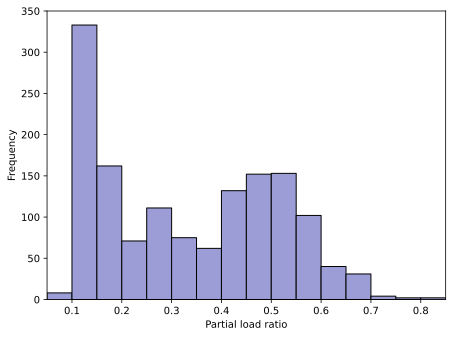

In [11]:
# Fig. 6 in the manuscript
plr_all = pd.concat(cl_selected).asfreq('30min')/7620

sns.histplot(plr_all, kde=False, bins=np.arange(0.05,0.9,0.05),color = '#9c9dd7',alpha=1)
plt.xlabel('Partial load ratio')
plt.ylabel('Frequency')
plt.xlim(0.05,0.85)
plt.ylim(0,350)
plt.tight_layout()
plt.savefig('./figures/Frequency_Distribution.pdf', bbox_inches='tight')

In [12]:
# Utility functions for calculating power consumption, load bias, and evaluating solution quality
def kw(p):
    # Function to calculate power consumption of chillers using polynomial coefficients with the input being partial load ratios
    return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()

def bias(p,load):
    # Function to calculate the difference between the actual chiller capacity and the required cooling load
    return sum(cap_array*p)-load

def eval_solutions(solutions):
    # Function to evaluate solution quality by calculating switching operations between consecutive time steps and power consumption (kWh) if applicable
    if solutions.shape[-1] != 6:
        solution_pre = solutions[0]
        diffs = [0]
        for i in range(1,len(solutions)):
            solution_now = solutions[i]
            diff = abs((solution_pre>0).astype(int)-(solution_now>0).astype(int)).sum()
            diffs += [diff]
            solution_pre = solution_now
        return np.array(diffs)
    else:
        solution_pre = solutions[0]
        powers = [kw(solution_pre)/2] # kWh
        diffs = [0]
        for i in range(1,len(solutions)):
            solution_now = solutions[i]
            diff = abs((solution_pre>0).astype(int)-(solution_now>0).astype(int)).sum()
            diffs += [diff]
            powers += [kw(solution_now)/2] # kWh
            solution_pre = solution_now
        return np.array(powers),np.array(diffs)

In [13]:
# Utility functions for multi-objective optimization using NSGA-II algorithm to balance power consumption and switching operations

import warnings
warnings.filterwarnings('ignore', message='invalid value encountered in power', 
                        category=RuntimeWarning, module='pymoo.*')

from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.repair import Repair
from pymoo.core.problem import StarmapParallelization

def flip_random_elements(arr, flip_probability=0.5, num_repeats=1):
    # Creates multiple variations of an array by randomly flipping binary elements with a given probability
    results = np.zeros((num_repeats, len(arr)), dtype=arr.dtype)
    for i in range(num_repeats):
        arr_copy = np.copy(arr)
        if np.random.rand() < flip_probability:        
            index_to_flip = np.random.randint(len(arr_copy))
            arr_copy[index_to_flip] = 1 - arr_copy[index_to_flip]
        if np.random.rand() < flip_probability:        
            index_to_flip = np.random.randint(len(arr_copy))
            arr_copy[index_to_flip] = 1 - arr_copy[index_to_flip]
        results[i] = arr_copy if arr_copy.sum() >0 else np.copy(arr)
    return results

class VariableSumToOneRepair(Repair):
    # Repair operator that adjusts solutions to meet the required cooling load while maintaining feasible operation ranges
    def __init__(self, load, best_x_previous):
        super().__init__()
        self.load = load
        self.best_x_previous = best_x_previous

    def _do(self, problem, pop, **kwargs):
        cur_number = (self.best_x_previous>0).astype(int)
        new_number = flip_random_elements(cur_number,num_repeats=pop.shape[0])
        cur_load = (pop*new_number*cap_array).sum(axis=1)
        cur_load[cur_load==0] = 1
        ratio = self.load/cur_load
        pop_new = ratio[:, np.newaxis]*(pop*new_number)
        pop_new[pop_new<0.3] = 0
        pop_new[pop_new>1] = 1
        return pop_new

class OptimizationProblem(ElementwiseProblem):
    # Defines the multi-objective optimization problem with power consumption and switching distance as objectives
    def __init__(self, load, best_x_previous, N, lb, ub,**kwargs):
        super().__init__(n_var=N, n_obj=2,n_ieq_constr=1, xl=lb, xu=ub)
        self.load = load
        self.best_x_previous = best_x_previous
    def kw(self,p):
        # Calculates power consumption based on partial load ratios
        return (abcd*np.array([np.ones(N),np.power(p,1),np.power(p,2),np.power(p,3)]).T).sum()
    def bias(self,p):
        # Calculates the absolute difference between provided capacity and required load
        return abs(sum(cap_array*p)-self.load)
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Evaluates a solution by calculating power consumption and distance from previous solution
        distance1 = np.linalg.norm(x - self.best_x_previous)
        distance2 = abs((self.best_x_previous>0).astype(int) - (x>0).astype(int)).sum()

        out["F"] = [self.kw(x), distance1 + distance2]
        out["G"] = [self.bias(x)-0.1]

def nsgaII_pymoo(load, best_x_previous, N):
    # Runs the NSGA-II algorithm to find Pareto-optimal solutions balancing power and switching operations
    lb = [0.3] * (N-0)
    ub = [1] * (N-0)
    problem = OptimizationProblem(load, best_x_previous, N, lb, ub)

    algorithm = NSGA2(
        pop_size=100,
        repair=VariableSumToOneRepair(load, best_x_previous),
    )

    res = minimize(problem, algorithm, termination=('n_gen', 200))
    return res.X, res.F

def dist(p1,p2):
    # Calculates the combined Euclidean and binary switching distance between two solutions
    dist1 = np.linalg.norm(p1 - p2)
    dist2 = abs((p1>0).astype(int) - (p2>0).astype(int)).sum()

    return dist1 + dist2

In [14]:
def eval_algorithms(seed,day,tolerance = 0.05,raw_result=False):

    test_cl = cl_selected[day]
    
    start_day = 0
    np.random.seed(seed)
    best_x_previous = de(test_cl[start_day],np.zeros(N))[0]
    solutions = [best_x_previous]
    # print(best_x_previous)
    for i in range(len(test_cl)-1):
        # print('nsga',i)
        load = test_cl[start_day+1]  # 示例负载值
        np.random.seed(seed)
        # print(load, best_x_previous, N)
        pareto_solutions, objective_values = nsgaII_pymoo(load, best_x_previous, N)
        # print(pareto_solutions)
        pareto_values = pd.DataFrame(objective_values,columns = ['Power','Distance']).sort_values(by='Distance')
        pareto_values_gb = pareto_values.groupby(pareto_values.Distance.apply(np.floor)).min().sort_index().Power
        pareto_values_gb_diff = (pareto_values_gb - pareto_values_gb.shift(-1))/pareto_values_gb
        pareto_values_gb_diff = pareto_values_gb_diff.fillna(0)
        first_index = pareto_values_gb_diff[pareto_values_gb_diff <= tolerance].first_valid_index() if len(pareto_values_gb) >1 else pareto_values_gb_diff.index[0]
        day_sele = pareto_values[pareto_values.Distance<first_index+1].sort_values(by='Power').index[0]
        # objective_values[day_sele]
        solutions.append(pareto_solutions[day_sele])
        best_x_previous = pareto_solutions[day_sele]
        start_day += 1
        # print(pareto_solutions[day_sele],load)
    
    solutions_de = []
    solutions_ga = []
    solutions_pso = []
    solutions_sa = []
    for i in range(len(test_cl)):
        # print('new',i)
        np.random.seed(seed)
        solutions_de.append(de(test_cl[i],solutions[i])[0])
        np.random.seed(seed)
        solutions_ga.append(ga(test_cl[i],solutions[i])[0])
        np.random.seed(seed)
        solutions_pso.append(pso(test_cl[i],solutions[i])[0])
        np.random.seed(seed)
        solutions_sa.append(sa(test_cl[i],solutions[i])[0])
    solutions_de = np.array(solutions_de)
    solutions_ga = np.array(solutions_ga)
    solutions_pso = np.array(solutions_pso)
    solutions_sa = np.array(solutions_sa)
    # print(solutions)
    return np.array([solutions_pso,solutions_ga,solutions_sa,solutions_de,solutions])



In [15]:
## Code to generate Gurobi results
# result_PLR_Gurobi = []
# for day in range(28):
#     test_cl = cl_selected[day]
#     temp = []
#     for load in test_cl:
#         temp.append(Gurobi(load)[0])
#     result_PLR_Gurobi.append(temp)
# result_PLR_Gurobi = np.array(result_PLR_Gurobi)
# result_PLR_Gurobi.shape
# np.save('./results/reault_PLR_Gurobi.npy',result_PLR_Gurobi)

result_PLR_Gurobi = np.load('./results/reault_PLR_Gurobi.npy')
result_PLR_Gurobi.shape # (num_days, num_timesteps_per_day, num_chillers)

(28, 48, 6)

In [16]:
## function to save results for metaheuristic algorithms and MOO under different random seeds and tolerance levels

def save_result(seed,tol):
    # Saves optimization results for each day using specified random seed and tolerance level, combining algorithm results with Gurobi solutions and organizing them in a directory structure.
    for day in range(28):
        result_1d = eval_algorithms(seed=seed,day=day,tolerance = tol,raw_result=True)
        file_name = f'./results/seed_{seed}_tol_{int(tol * 100) % 100:02d}/day_{day}.npy'
        directory = os.path.dirname(file_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        np.save(file_name, result_1d)


In [17]:
## Load and process chiller sequencing results for baseline configuration
## This code loads optimization results for all 28 days using random seed 0 and 5% tolerance level,
## then evaluates the switching frequency for each algorithm-day-chiller combination
## Uncomment the code below to generate results again

# save_result(seed=0,tol=0.05)

result_Ntot_all_seed0_tol05 = []
for day in range(28):
    filename = f'./results/seed_0_tol_05/day_{day}.npy'
    temp = np.load(filename)

    result_PLR_Gurobi_slice = result_PLR_Gurobi[day]
    temp = np.insert(temp, -1, result_PLR_Gurobi_slice, axis=0)

    temp_evaluated = np.zeros((6, 6),dtype=int)
    for algorithm in range(6):
        for chiller in range(6):
            temp_evaluated[algorithm, chiller] = eval_solutions(temp[algorithm, :, chiller].reshape(-1, 1)).sum()
    result_Ntot_all_seed0_tol05.append(temp_evaluated)
result_Ntot_all_seed0_tol05 = np.array(result_Ntot_all_seed0_tol05)
result_Ntot_all_seed0_tol05 = np.transpose(result_Ntot_all_seed0_tol05, (1, 0, 2))


result_Ntot_all_seed0_tol05.shape # (num_algorithms, num_days, num_chillers)

(6, 28, 6)

In [18]:
## Generate and load Part Load Ratio (PLR) results across multiple random seeds
## This code generates optimization results for all 28 days using 10 different random seeds (0-9) with 5% tolerance level,
## then loads and organizes the results into a 5D array with dimensions: (algorithm, random_seed, day, time_interval, chiller)
## The commented code below shows the process used to generate the saved results file
## Uncomment the code below would generate results again

# for seed in range(10):
#     save_result(seed=seed,tol=0.05)

# result_PLR_all_seed10_tol05 = []
# for seed in range(10):
#     temp_seed = []
#     for day in range(28):
#         filename = f'./results/seed_{seed}_tol_05/day_{day}.npy'
#         temp = np.load(filename)

#         result_PLR_Gurobi_slice = result_PLR_Gurobi[day]
#         temp = np.insert(temp, -1, result_PLR_Gurobi_slice, axis=0)
#         temp_seed.append(temp)
#     result_PLR_all_seed10_tol05.append(temp_seed)
# result_PLR_all_seed10_tol05 = np.array(result_PLR_all_seed10_tol05)
# result_PLR_all_seed10_tol05 = np.transpose(result_PLR_all_seed10_tol05, (2, 0, 1, 3, 4))
# np.save('./results/result_PLR_all_seed10_tol05.npy',result_PLR_all_seed10_tol05)


result_PLR_all_seed10_tol05 = np.load('./results/result_PLR_all_seed10_tol05.npy')
result_PLR_all_seed10_tol05.shape  # (num_algorithms, num_seeds, num_days, num_timesteps_per_day, num_chillers)

(6, 10, 28, 48, 6)

In [19]:
# This code loads or generates evaluation results for the MOO algorithm across different days, seeds, and tolerance values
# The commented section shows how the data was originally generated:
# 1. For each day (28 days total)
# 2. For each random seed (10 seeds total)
# 3. For each tolerance value (0.01 to 0.10 with 0.01 step)
# 4. Load the results file and evaluate the MOO solution
# Uncommenting the code below would generate results again

# for seed in range(10):
#     for tol in np.arange(0.01, 0.11, 0.01):
#         save_result(seed=seed,tol=tol)
# result_eval_MOO_seed10_tolX = []
# for day in range(28):
#     temp_day = []
#     for seed in range(10):
#         temp_seed = []
#         for tol in np.arange(0.01, 0.11, 0.01):
#             filename = f'./results/seed_{seed}_tol_{int(tol * 100) % 100:02d}/day_{day}.npy'
#             temp = np.load(filename)
#             temp_seed.append(eval_solutions(temp[-1])) # select MOO result
#         temp_day.append(temp_seed)
#     result_eval_MOO_seed10_tolX.append(temp_day)

# result_eval_MOO_seed10_tolX = np.array(result_eval_MOO_seed10_tolX)
# np.save('./results/result_eval_MOO_seed10_tolX.npy', result_eval_MOO_seed10_tolX)

result_eval_MOO_seed10_tolX = np.load('./results/result_eval_MOO_seed10_tolX.npy')
result_eval_MOO_seed10_tolX.shape # (num_days, num_seeds, num_tolerance_levels, num_metrics, num_timesteps_per_day)


(28, 10, 10, 2, 48)

In [20]:
# This code loads or would generate evaluation results for all algorithms (5% tolerance for MOO
# The commented section shows how the data was originally generated:
# 1. For each day (28 days total)
# 2. For each random seed (10 seeds total)
# 3. For each algorithm (5 algorithms)
# 4. Load the results file and evaluate the solution
# Uncommenting the code below would generate results again

# result_eval_all_seed10_tol05 = []
# for day in range(28):
#     temp_day = []
#     for seed in range(10):
#         temp_seed = []
#         for algorithm in range(5):
#             filename = f'./results/seed_{seed}_tol_05/day_{day}.npy'
#             temp = np.load(filename)
#             temp_seed.append(eval_solutions(temp[algorithm]))
#         temp_day.append(temp_seed)
#     result_eval_all_seed10_tol05.append(temp_day)

# result_eval_all_seed10_tol05 = np.array(result_eval_all_seed10_tol05)
# np.save('./results/result_eval_all_seed10_tol05.npy',result_eval_all_seed10_tol05)

result_eval_all_seed10_tol05 = np.load('./results/result_eval_all_seed10_tol05.npy')
result_eval_all_seed10_tol05.shape # (num_days, num_seeds, num_algorithms, num_metrics, num_timesteps_per_day)

(28, 10, 5, 2, 48)

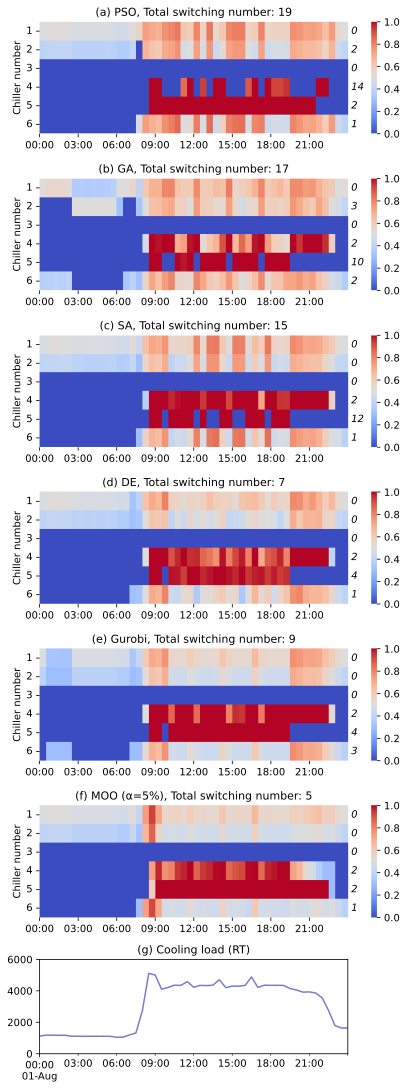

In [21]:
# Fig. 16 in the manuscript
# Visualize PLR heatmap for a specific day (day 0) with switching numbers for each algorithm
day = 0

result_1d = np.load(f'./results/seed_0_tol_05/day_{day}.npy')

result_PLR_Gurobi_slice = result_PLR_Gurobi[day]
result_1d = np.insert(result_1d, -1, result_PLR_Gurobi_slice, axis=0)

algorithms_sort = ["PSO", "GA", "SA", "DE","Gurobi", "MOO"]
times = ["{:02d}:{:02d}".format(h, m) for h in range(24) for m in (0, 30)][:-1]
Chillers = ['1', '2', '3', '4', '5', '6']

time_indices = list(range(0, len(times), 6))
selected_times = [times[i] for i in time_indices]

fig, axes = plt.subplots(7, 1, figsize=(7, 19))
plt.subplots_adjust(hspace=0.4)
axes[6].set_position(Bbox([[0.125, 0.125], [0.737, 0.194]]))

mapping = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f',6:'g'}

for i in range(6):
    sns.heatmap(result_1d[i].T, ax=axes[i], cmap='coolwarm', cbar=True,rasterized=True,cbar_kws={"pad": 0.06},vmin=0,vmax=1)
    axes[i].set_xticks(time_indices)
    axes[i].set_xticklabels(selected_times, rotation=0)
    axes[i].set_yticks(np.arange(len(Chillers))+0.5)
    axes[i].set_yticklabels([item+''*0 for item in Chillers],va='center',rotation=0)
    axes[i].set_ylabel('Chiller number')
    if i ==5:
        axes[i].set_title(f"({mapping[i]}) {algorithms_sort[i]} (⍺=5%), Total switching number: {eval_solutions(result_1d[i])[1].sum()}",fontsize=11)
    else:
        axes[i].set_title(f"({mapping[i]}) {algorithms_sort[i]}, Total switching number: {eval_solutions(result_1d[i])[1].sum()}",fontsize=11)
        
    cbar = axes[i].collections[0].colorbar
    cbar.set_label(None)

    ax_twin = axes[i].twinx()
    ax_twin.spines['top'].set_visible(False)
    ax_twin.spines['bottom'].set_visible(False)
    ax_twin.spines['left'].set_visible(False)
    ax_twin.spines['right'].set_visible(False)
    ax_twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    ax_twin.set_yticks(np.arange(len(Chillers))+1)
    ax_twin.set_yticklabels([eval_solutions(result_1d[i][:,5-j].reshape(-1, 1)).sum() for j in range(6)],va='center',rotation=0)
    ax_twin.set_ylim(0.5,6.5)
    
    for label in ax_twin.get_yticklabels():
        label.set_horizontalalignment('left')
        label.set_position((label.get_position()[0] - 0.012, label.get_position()[1]))
        label.set_fontstyle('italic')

plot_CL = cl_selected[day].copy()
plot_CL[plot_CL.index[-1] + pd.Timedelta(minutes=30)] = plot_CL[-1]
plot_CL.plot(ax=axes[6])
xticks = axes[6].get_xticks()
xticklabels = axes[6].get_xticklabels()

xticks = xticks[:-1]
xticklabels = xticklabels[:-1]
axes[6].set_xticks(xticks)
axes[6].set_xticklabels(xticklabels)
axes[6].set_ylim(0,6000)
axes[6].set_title('(g) Cooling load (RT)',fontsize=11)

plt.savefig(f'./figures/PLR_heatmap_day{day}.pdf', bbox_inches='tight')

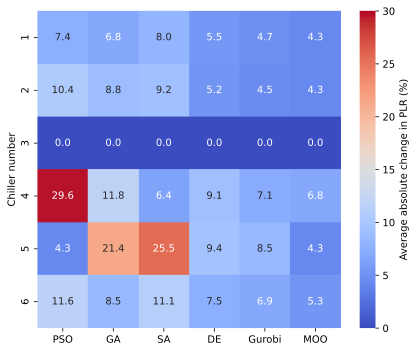

In [22]:
# Fig. 17 in the manuscript
# Calculate and visualize the average absolute change in PLR for each algorithm and chiller
day = 0
result_1d = np.load(f'./results/seed_0_tol_05/day_{day}.npy')

result_PLR_Gurobi_slice = result_PLR_Gurobi[day]
result_1d = np.insert(result_1d, -1, result_PLR_Gurobi_slice, axis=0)

average_absolute_change = np.mean(np.abs(np.diff(result_1d, axis=1)), axis=1)*100

column_labels = ["PSO", "GA", "SA", "DE", "Gurobi", "MOO"]
row_labels = ['1', '2', '3', '4', '5', '6']

plt.figure(figsize=(6, 5))
ax = sns.heatmap(average_absolute_change.T, annot=True, fmt=".1f", cmap="coolwarm",rasterized=True,
                 xticklabels=column_labels, yticklabels=row_labels,vmin=0,vmax=30,cbar_kws={'label': 'Average absolute change in PLR (%)'})
ax.set_ylabel('Chiller number')
plt.tight_layout()

plt.savefig(f'./figures/PLR_aac_day{day}.pdf', bbox_inches='tight')


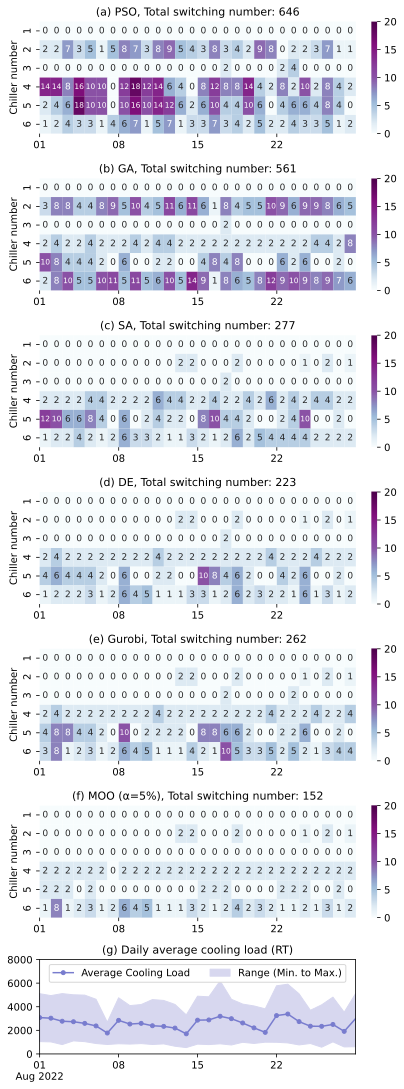

In [23]:
# Fig. 15 in the manuscript
# Visualize total switching numbers for each algorithm across all days
import matplotlib.colors as mcolors

algorithms_sort = ["PSO", "GA", "SA", "DE","Gurobi", "MOO"]
total_switching_numbers = {algo: result_Ntot_all_seed0_tol05[i, :, :] for i, algo in enumerate(algorithms_sort)}
fig, axes = plt.subplots(7, 1, figsize=(7, 19))
plt.subplots_adjust(hspace=0.4)
axes[6].set_position(Bbox([[0.125, 0.125], [0.752, 0.194]]))

cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['#f0f6fa','#98a6cc','#4d0d4e'])

for i, algo in enumerate(algorithms_sort):
    sns.heatmap(total_switching_numbers[algo].T, ax=axes[i], cmap=BuPu_new, annot=True, fmt="d",vmin=0,vmax=20,cbar_kws = {'pad': 0.04})
    axes[i].set_title(algo)
    
    if i ==5:
        axes[i].set_title(f"({mapping[i]}) {algorithms_sort[i]} (⍺=5%), Total switching number: {total_switching_numbers[algo].sum()}",fontsize=11)
    else:
        axes[i].set_title(f"({mapping[i]}) {algorithms_sort[i]}, Total switching number: {total_switching_numbers[algo].sum()}",fontsize=11)
    
    axes[i].set_ylabel('Chiller number')
    axes[i].set_yticks(np.arange(0.5,6.5,1),np.arange(len(Chillers))+1)
    if i == 7:
        axes[i].set_xticks(np.arange(0,27,7),['01\nAug\n2022','08', '15', '22'],rotation=0)
    else:
        axes[i].set_xticks(np.arange(0,27,7),['01','08', '15', '22'],rotation=0)
    for text in axes[i].texts:
        if int(text.get_text()) > 9:
            text.set_fontsize(7.5)
        else:
            text.set_fontsize(9)

avg_cl = np.mean(cl_selected[:29], axis=1)
cl_max = np.max(cl_selected[:29], axis=1)
cl_min = np.min(cl_selected[:29], axis=1)

dates = pd.date_range(start="2022-08-01", periods=30)
axes[6].plot(avg_cl, marker='o', label='Average Cooling Load',markevery=[i for i in range(len(avg_cl)-1)],markersize=4)
axes[6].fill_between(range(29),cl_min, cl_max, color='#d7d7ef', label='Range (Min. to Max.)')
axes[6].set_xlim(0,28)
axes[6].set_ylim(0,8000)
axes[6].legend(edgecolor='#d6d6d6',framealpha=1,ncol=2,loc='upper center')
axes[6].set_title('(g) Daily average cooling load (RT)',fontsize=11)
axes[6].set_xticks(np.arange(0,27,7),['01\nAug 2022','08', '15', '22'],rotation=0)

plt.savefig(f'./figures/sntot_heatmap.pdf', bbox_inches='tight')

In [24]:
# Load and preprocess results data for tolerance analysis and algorithm comparison
result_eval_MOO_seed10_tolX = np.load('./results/result_eval_MOO_seed10_tolX.npy')

days = np.arange(28)
seeds = np.arange(10)
tolerances = np.linspace(0.01, 0.1, 10)
items = ['Energy', 'Total switching number']
times = np.arange(48)

multi_index = pd.MultiIndex.from_product([days, seeds, tolerances, items, times], 
                                         names=['Day', 'Seed', 'Tolerance', 'Item', 'Time'])

reshaped_data = result_eval_MOO_seed10_tolX.reshape(-1)

df = pd.DataFrame(reshaped_data, index=multi_index, columns=['Value'])

df_tol = df.reset_index()

df_tol.loc[df_tol.Item == 'Energy','Value'] = (df_tol.loc[df_tol.Item == 'Energy','Value']/1000)
df_tol.Tolerance = df_tol.Tolerance.round(2).astype(str)

result_eval_all_seed10_tol05 = np.load('./results/result_eval_all_seed10_tol05.npy')
algorithms = ["MOO", "DE", "GA", "PSO", "SA"]
items = ["Energy", "Total switching number"]
times = np.arange(48)

multi_index = pd.MultiIndex.from_product([days, seeds, algorithms, items, times], 
                                         names=["Day", "Seed", "Algorithm", "Item", "Time"])

reshaped_results = result_eval_all_seed10_tol05.reshape(-1)

df_results = pd.DataFrame(reshaped_results, index=multi_index, columns=["Value"]).reset_index()

df_results = df_results[["Seed", "Algorithm",'Day', "Time", "Item", "Value"]]
df_results.loc[df_results.Item == 'Energy','Value'] = (df_results.loc[df_results.Item == 'Energy','Value']/1000)

df_tol = df_tol[df_tol.Day <28]
df_tol.Tolerance = (df_tol.Tolerance.astype(float)*100).astype(int)
df_results = df_results[df_results.Day <28]

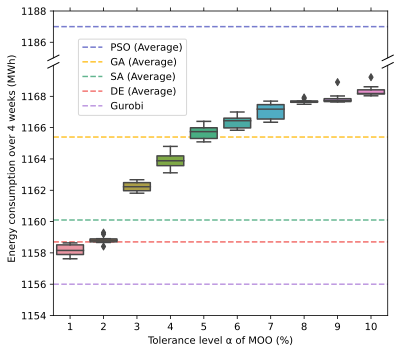

In [25]:
# Fig. 12 in the manuscript
# Plot energy consumption comparison across different tolerance levels for MOO algorithm

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1.5, 8]}, figsize=(6, 5.5))
fig.subplots_adjust(hspace=0.05)

df_sum = df_tol[df_tol.Item == 'Energy'].groupby(['Tolerance','Seed'])['Value'].sum().reset_index()

ax1.axhline(y=1187.0, linestyle='--', label='PSO (Average)', c=colors[0]) # averaged data from algo_avg_all
ax2.axhline(y=1165.4, linestyle='--', label='GA (Average)', c=colors[1])
ax2.axhline(y=1160.1, linestyle='--', label='SA (Average)', c=colors[2])
ax2.axhline(y=1158.7, linestyle='--', label='DE (Average)', c=colors[3])
ax2.axhline(y=1156.0, linestyle='--', label='Gurobi', c=colors[4])

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles + handles2, labels + labels2, bbox_to_anchor=(0.06, 0.78), edgecolor='#d6d6d6', framealpha=1)

sns.boxplot(x='Tolerance', y='Value', data=df_sum, ax=ax2,
            boxprops={"zorder":10},
            whiskerprops={"zorder":10},
            zorder=10)

ax1.set_ylim(592.5*2, 594*2)
ax2.set_ylim(577*2, 584.99*2)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_ylabel(' '*20+'Energy consumption over 4 weeks (MWh)')
ax2.set_xlabel('Tolerance level ⍺ of MOO (%)')

plt.savefig('./figures/energy_consumption_tolerance_levels_moo.pdf', bbox_inches='tight')

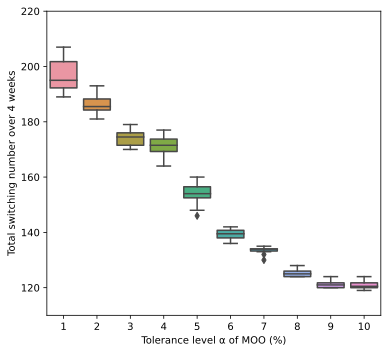

In [26]:
# Fig. 7 in the manuscript
# Plot total switching number comparison across different tolerance levels for MOO algorithm
fig, ax = plt.subplots(figsize=(6, 5.5))
df_sum_switching = df_tol[df_tol.Item == 'Total switching number'].groupby(['Tolerance', 'Seed'])['Value'].sum().reset_index()

sns.boxplot(x='Tolerance', y='Value', data=df_sum_switching, ax=ax,
            boxprops={"zorder":10},
            whiskerprops={"zorder":10},
            zorder=10)

ax.set_xlabel('Tolerance level ⍺ of MOO (%)')
ax.set_ylabel('Total switching number over 4 weeks')
ax.set_ylim(110,220)

plt.savefig('./figures/total_switching_number_tolerance_levels_moo.pdf', bbox_inches='tight')

plt.show()

In [27]:
# Calculate average energy consumption and switching numbers for different tolerance levels
tol_avg = pd.DataFrame(columns=['Average energy consumption', 'Average Ntot'])
tol_avg.index.name = 'Algorithm'

for tol in tolerances*100:
    tol = int(tol)
    p1 = df_sum[df_sum.Tolerance==tol].Value.mean()
    p2 = df_sum_switching[df_sum_switching.Tolerance==tol].Value.mean()
    tol_avg.loc[f'{tol}'] = [round(p1,1),p2]

# Calculate energy consumption and switching numbers across different algorithms
df_sum = df_results[df_results.Item == 'Energy'].groupby(['Algorithm', 'Seed'])['Value'].sum().reset_index()

df_sum_switching = df_results[df_results.Item == 'Total switching number'].groupby(['Algorithm', 'Seed'])['Value'].sum().reset_index()

algo_avg = pd.DataFrame(columns=['Average energy consumption', 'Average Ntot'])
algo_avg.index.name = 'Algorithm'

for algo in algorithms_sort:
    if algo == 'Gurobi':
        p1 = sum([eval_solutions(result_PLR_Gurobi[i])[0].sum() for i in range(28)])/1000 # *10^3 kWh
        p2 = sum([eval_solutions(result_PLR_Gurobi[i])[1].sum() for i in range(28)])
    else:
        p1 = df_sum[df_sum_switching.Algorithm==algo].Value.mean()
        p2 = df_sum_switching[df_sum_switching.Algorithm==algo].Value.mean()
    if algo != 'MOO':
        algo_avg.loc[algo] = [round(p1,1),p2]
        
algo_avg = algo_avg.loc[['PSO','GA', 'SA']] if len(algo_avg) == 3 else algo_avg.loc[['PSO','GA', 'SA', 'DE','Gurobi']]

,Average energy consumption,Average Ntot
PSO,1187.0,596.4
GA,1165.4,371.5
SA,1160.1,279.2
DE,1158.7,242.7
Gurobi,1156.0,262.0
MOO(1%),1158.2,196.9
MOO(2%),1158.8,186.5
MOO(3%),1162.2,174.3
MOO(4%),1163.9,171.4
MOO(5%),1165.7,153.7


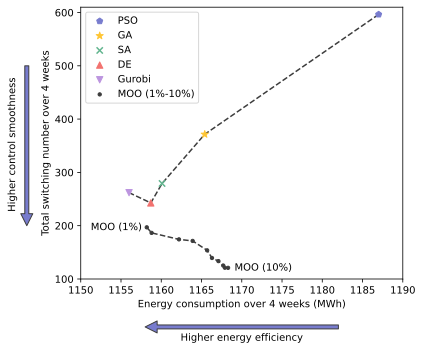

In [28]:
# Fig. 13 in the manuscript
# Plot energy consumption vs switching number trade-off for different algorithms
algo_avg_all = pd.concat([algo_avg,tol_avg])
algo_avg_all.index = list(algo_avg_all.index[:-10]) + ['MOO({}%)'.format(i) for i in range(1, 11)]
fig,ax = plt.subplots(figsize=(6,5))

plt.scatter(*algo_avg_all.loc['PSO'].values, s=40,c=colors[0],marker='p',zorder=5,label='PSO')
plt.scatter(*algo_avg_all.loc['GA'].values, s=55,c=colors[1],marker='*',zorder=5,label='GA')
plt.scatter(*algo_avg_all.loc['SA'].values, s=40,c=colors[2],marker='x',zorder=5,label='SA')
plt.scatter(*algo_avg_all.loc['DE'].values, s=40,c=colors[3],marker='^',zorder=5,label='DE')
plt.scatter(*algo_avg_all.loc['Gurobi'].values, s=40,c=colors[4],marker='v',zorder=5,label='Gurobi')

algo_avg_all.iloc[:-10].plot(x='Average energy consumption',y= 'Average Ntot',marker='',ax=ax,c=colors[7],label='',linestyle='--')
algo_avg_all.iloc[-10:].plot(x='Average energy consumption',y= 'Average Ntot',marker='',markersize=8,c=colors[7],ax=ax,label='',zorder=3,linestyle='--')
algo_avg_all.iloc[-10:].plot.scatter(x='Average energy consumption',y= 'Average Ntot',marker='.',s=45,c=colors[7],ax=ax,label='MOO (1%-10%)',zorder=4)

plt.text(algo_avg_all.iloc[-10][0]-0.6,algo_avg_all.iloc[-10][1],'MOO (1%)',ha='right',va='center')
plt.text(algo_avg_all.iloc[-1][0]+0.8,algo_avg_all.iloc[-1][1],'MOO (10%)',ha='left',va='center')

plt.xlabel('Energy consumption over 4 weeks (MWh)\n\n\nHigher energy efficiency')
plt.ylabel('Higher control smoothness \n\n\nTotal switching number over 4 weeks')
plt.xlim(1150,1190)
plt.ylim(100,610)

plt.annotate( '', xy=(1143.3, 200), xytext=(1143.3,500), ha='center',arrowprops={'shrink':0.0,'facecolor':colors[0],'edgecolor':colors[7]},annotation_clip=False,rotation=90)
plt.annotate( '', xy=(1158, 10), xytext=(1182, 10), ha='center',arrowprops={'shrink':0.0,'facecolor':colors[0],'edgecolor':colors[7]},annotation_clip=False)

plt.legend(edgecolor='#d6d6d6',framealpha=1,ncol=1)
plt.tight_layout()
plt.savefig('./figures/efficiency_robustness_tradeoff.pdf', bbox_inches='tight')
algo_avg_all # Energy consumption data used in Fig. 12

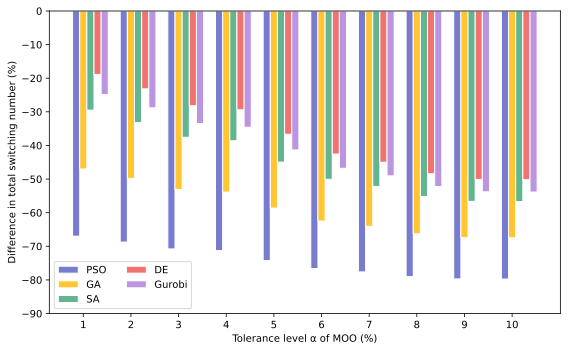

In [29]:
# Fig. 8 in the manuscript
#  Calculate and plot the percentage difference in total switching number between MOO and other algorithms
improvements = pd.DataFrame(index=tol_avg.index)

for algo_index, algo_row in algo_avg.iterrows():
    improvements[algo_index] = ((tol_avg['Average Ntot'] - algo_row['Average Ntot']) / algo_row['Average Ntot']) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.15
indices = np.arange(len(tol_avg.index))

for i, algo in enumerate(algo_avg.index):
    ax.bar(indices + i * bar_width, improvements[algo], width=bar_width, label=algo, color=colors[i],edgecolor='w')

plt.xlabel('Tolerance level ⍺ of MOO (%)')
plt.ylabel('Difference in total switching number (%)')
plt.xticks(indices + bar_width, labels=tol_avg.index)
plt.legend(edgecolor='#d6d6d6',framealpha=1,ncol=2)
plt.ylim(-90,0)
plt.tight_layout()
plt.savefig('./figures/ntot_reduction.pdf', bbox_inches='tight')


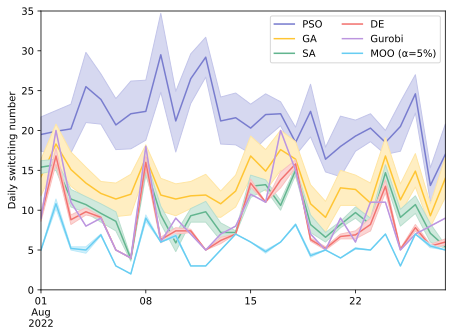

In [30]:
# Fig. 9 in the manuscript
# Plot daily switching number with confidence intervals for each algorithm
df_switching = df_results[(df_results['Item'] == 'Total switching number')]
df_switching_ = df_switching.groupby(['Algorithm','Day','Seed'])['Value'].sum().reset_index()
switching_Gurobi = np.array([eval_solutions(result_PLR_Gurobi[i])[1].sum() for i in range(28)])
df_switching_ = df_switching_._append(df_switching_.tail(280)).reset_index().drop(['index'],axis=1)
df_switching_.loc[1400:,'Algorithm'] = 'Gurobi'
df_switching_.loc[1400:,'Value'] = np.repeat(switching_Gurobi,10)

df_switching_.Algorithm = pd.Categorical(df_switching_.Algorithm, categories=["PSO", "GA", "SA", "DE","Gurobi","MOO"], ordered=True) 
df_switching_.Algorithm = pd.Categorical(df_switching_.Algorithm.replace('MOO', 'MOO (⍺=5%)'), categories=["PSO", "GA", "SA", "DE","Gurobi","MOO (⍺=5%)"], ordered=True) 

ax = sns.lineplot(df_switching_,x='Day',y='Value',hue='Algorithm',errorbar=('ci', 75),estimator="mean")

for i,line in enumerate(ax.lines):
    line.set_alpha(1)
    line.set_zorder(i+3)

for i,collection in enumerate(ax.collections):
    c = collection.get_edgecolor()
    collection.set_facecolor(c[:,:3]*0.3 + np.array([[1,1,1]])*0.7)
    collection.set_edgecolor(c[:,:3]*0.45 + np.array([[1,1,1]])*0.55)
    collection.set_alpha(1)
    collection.set_zorder(i+2)

for spine in plt.gca().spines.values():
    spine.set_zorder(12)

plt.legend(title=None,edgecolor='#d6d6d6',framealpha=1,ncol=2)
plt.xlim(0,27)
plt.xticks(np.arange(0,27,7),['01\nAug\n2022','08', '15', '22'])
plt.ylim(0,35)
plt.ylabel('Daily switching number')
plt.xlabel('')
plt.tight_layout()
plt.savefig('./figures/daily_switching_difference.pdf', bbox_inches='tight')


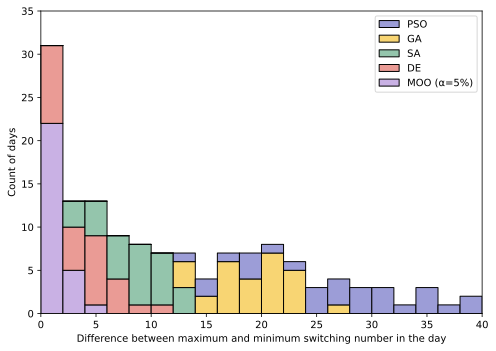

In [31]:
## Fig. 10 in the manuscript
# Calculate and visualize the daily difference between maximum and minimum switching numbers for each algorithm
df_daily_maxmin_diff = (df_switching_.groupby(['Algorithm','Day'])['Value'].max()-df_switching_.groupby(['Algorithm','Day'])['Value'].min()).reset_index()
df_daily_maxmin_diff['Value'] = df_daily_maxmin_diff['Value'].astype(int)
df_daily_maxmin_diff = df_daily_maxmin_diff[df_daily_maxmin_diff['Algorithm'] != 'Gurobi']

df_daily_maxmin_diff.Algorithm = df_daily_maxmin_diff.Algorithm.astype(str)

plt.figure(figsize=(7,5))

ax = sns.histplot(data=df_daily_maxmin_diff, 
                  x='Value', 
                  hue='Algorithm',
                  multiple='stack',
                  bins=20,
                  palette=['#9c9dd7', '#f8d573', '#94c5ac', '#ea9b95', '#c9b1e4'],
                  alpha=1)

legend = ax.get_legend()
legend.set_title('')
legend.set_frame_on(True)
legend.get_frame().set_edgecolor('#d6d6d6')
legend.get_frame().set_alpha(1)

plt.ylabel('Count of days')
plt.xlabel('Difference between maximum and minimum switching number in the day')
plt.ylim(0,35)
plt.xlim(0,40)
plt.tight_layout()
plt.savefig('./figures/count_of_max_min_days.pdf', bbox_inches='tight')

In [32]:
## Table 3 in the manuscript
Gurobi_weekly = np.array([eval_solutions(result_PLR_Gurobi[i])[1].sum() for i in range(28)]).reshape(4,-1)
Gurobi_weekly.std(axis=0).round(2),Gurobi_weekly.mean(axis=0).round(2)

max_series = df_switching_.groupby(['Algorithm','Seed'])['Value'].sum().reset_index().groupby(['Algorithm'])['Value'].max()
min_series = df_switching_.groupby(['Algorithm','Seed'])['Value'].sum().reset_index().groupby(['Algorithm'])['Value'].min()
mean_series = df_switching_.groupby(['Algorithm','Seed'])['Value'].sum().reset_index().groupby(['Algorithm'])['Value'].mean()

df_summary = pd.concat([mean_series,max_series,min_series], axis=1)
df_summary.columns = ['Average', 'Maximum', 'Minimum']
df_summary['Max-Min'] = df_summary['Maximum'] - df_summary['Minimum']
df_summary.to_csv('./figures/switching_summary.csv')
df_summary

,Average,Maximum,Minimum,Max-Min
Algorithm,,,,
PSO,596.4,928.0,425.0,503.0
GA,371.5,561.0,223.0,338.0
SA,279.2,307.0,267.0,40.0
DE,242.7,258.0,223.0,35.0
Gurobi,262.0,262.0,262.0,0.0
MOO (⍺=5%),153.7,160.0,146.0,14.0


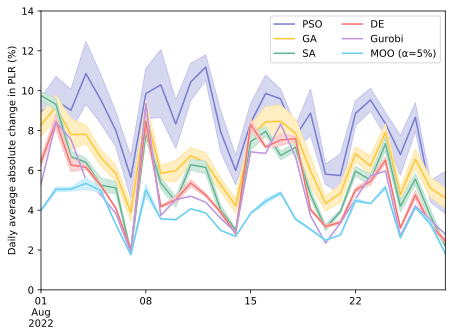

In [33]:
## Fig. 11 in the manuscript
aac = np.mean(np.abs(np.diff(result_PLR_all_seed10_tol05, axis=3)), axis=(3,4))

multi_index = pd.MultiIndex.from_product([['PSO', 'GA', 'SA', 'DE', 'Gurobi', 'MOO'], range(10), range(28)], 
                                         names=["Algorithm", "Seed", "Day"])

df_aac = pd.DataFrame(aac.reshape(-1)*100, index=multi_index, columns=["Value"]).reset_index()
df_aac_ = df_aac.groupby(['Algorithm', 'Day', 'Seed'])['Value'].sum().reset_index()
switching_Gurobi = np.array([eval_solutions(result_PLR_Gurobi[i])[1].sum() for i in range(28)])
df_aac_ = df_aac_._append(df_aac_.tail(280)).reset_index().drop(['index'], axis=1)

df_aac_.Algorithm = pd.Categorical(df_aac_.Algorithm, 
                                  categories=["PSO", "GA", "SA", "DE", "Gurobi", "MOO"], 
                                  ordered=True)

df_aac_.Algorithm = pd.Categorical(df_aac_.Algorithm.replace('MOO', 'MOO (⍺=5%)'), 
                                  categories=["PSO", "GA", "SA", "DE", "Gurobi", "MOO (⍺=5%)"], 
                                  ordered=True)

ax = sns.lineplot(df_aac_, x='Day', y='Value', hue='Algorithm', errorbar=('ci', 75))

for i, line in enumerate(ax.lines):
    line.set_alpha(1)
    line.set_zorder(i+3)

for i, collection in enumerate(ax.collections):
    c = collection.get_edgecolor()
    collection.set_facecolor(c[:,:3]*0.3 + np.array([[1,1,1]])*0.7)
    collection.set_edgecolor(c[:,:3]*0.45 + np.array([[1,1,1]])*0.55)
    collection.set_alpha(1)
    collection.set_zorder(i+2)

for spine in plt.gca().spines.values():
    spine.set_zorder(12)

plt.legend(title=None, edgecolor='#d6d6d6', framealpha=1, ncol=2)
plt.xlim(0, 27)
plt.xticks(np.arange(0, 27, 7), ['01\nAug\n2022', '08', '15', '22'])
plt.ylim(0, 14)
plt.ylabel('Daily average absolute change in PLR (%)')
plt.xlabel('')
plt.tight_layout()
plt.savefig('./figures/daily_aac_difference.pdf', bbox_inches='tight')


In [34]:
## Table 4 in the manuscript
max_series = df_aac.groupby(['Algorithm','Day'])['Value'].max().reset_index()
min_series = df_aac.groupby(['Algorithm','Day'])['Value'].min().reset_index()
mean_series = df_aac.groupby(['Algorithm','Day'])['Value'].mean().reset_index()
max_min_series = max_series.copy()
max_min_series.Value -= min_series.Value

max_series = max_series.groupby(['Algorithm'])['Value'].mean()
min_series = min_series.groupby(['Algorithm'])['Value'].mean()
mean_series = mean_series.groupby(['Algorithm'])['Value'].mean()
max_min_series = max_min_series.groupby(['Algorithm'])['Value'].mean()


df_summary = pd.concat([mean_series,max_series,min_series,max_min_series], axis=1)
df_summary.columns = ['Average', 'Maximum', 'Minimum','Max-Min']
df_summary = df_summary.loc[algorithms_sort]
df_summary.round(2)

,Average,Maximum,Minimum,Max-Min
Algorithm,,,,
PSO,8.34,13.19,4.95,8.24
GA,6.51,8.92,4.61,4.31
SA,5.61,7.34,4.38,2.96
DE,5.16,5.80,4.64,1.16
Gurobi,4.93,4.93,4.93,0.00
MOO,3.79,4.06,3.55,0.51
